# Clean Data

Remove NaNs and zeroes from the vv band and create a new dataset. NaNs and zeroes are often representative of lapses in data collection or errors in collection and/or processing of raw satellite data. We will optimize the data for ML by removing erreneous data. Here I will handle NaNs and zeroes by removing them so there is a continuous dataset in terms of velocity values.

---

## 1. Load packages and open datasets

In [141]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [74]:
ziVelSeries = xr.open_dataset('../data/raw/ZachariaeIsstromVelocitySeries.nc')

The data come in an Xarray Dataset, where there are 3 bands with associated values in the `VelocitySeries`. The `vx` band represents the East-West movement, the `vy` band represents the North-South movement, and the `vv` band represents changes in flow relative to the satellite. The `vv` band is used for glacier velocity mapping and analysis.

There is a timestamp for each data point which is associated with the velocity at that time. The data come with `x` and `y` coordinates for mapping.

In [142]:
# Visualize the data before cleaning
ziVelSeries

<xarray.Dataset> Size: 482MB
Dimensions:         (time: 443, band: 3, x: 301, y: 301)
Coordinates:
  * time            (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-04...
  * band            (band) <U2 24B 'vx' 'vy' 'vv'
  * x               (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
  * y               (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06 -1.14e+06
    id              (time) <U115 204kB ...
    epsg            int64 8B 3413
    name            <U4 16B 'temp'
    time1           (time) datetime64[ns] 4kB ...
    time2           (time) datetime64[ns] 4kB ...
    _FillValue      float64 8B -1.0
Data variables:
    spatial_ref     int64 8B ...
    VelocitySeries  (time, band, y, x) float32 482MB nan nan ... 6.525 0.5483

## 2. Plot the vv band

The vv band contains the velocity values that will be used for prediction.

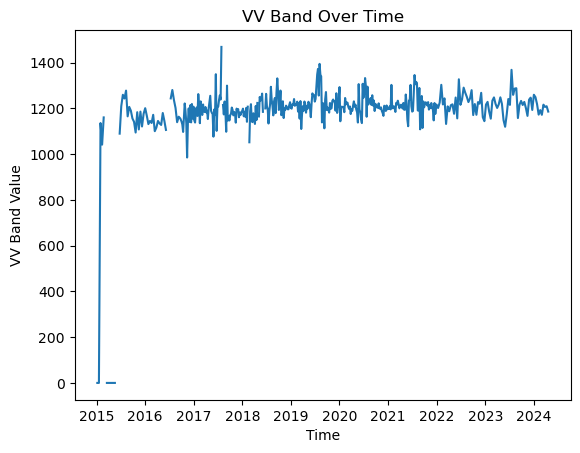

In [76]:
plt.title('VV Band Over Time')
plt.xlabel('Time')

# Select the 'vv' band from the dataset
vv_band = ziVelSeries.sel(band='vv')
vv_band['VelocitySeries'][:, 0, 0].plot()

# Plot and add labels
plt.title('VV Band Over Time')
plt.xlabel('Time')
plt.ylabel('VV Band Value')
plt.show()

## 3. Remove NaNs and zeroes from the dataset
Remove NaNs and zeroes from the vv band and create a new dataset. By plotting the two together, you can see that zero values in 2015 were removed.

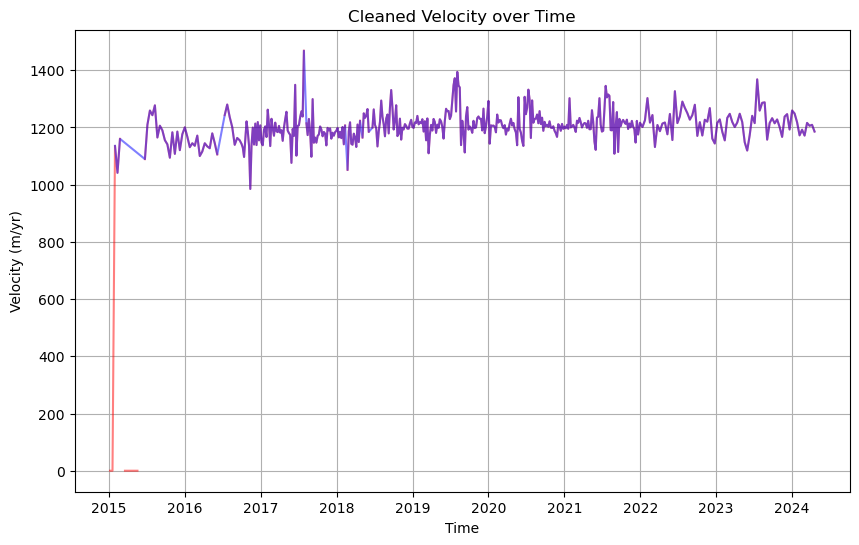

In [151]:
# Drop NaNs from the array and corresponding time values
mask = ~np.isnan(vv_band['VelocitySeries'][:,0,0]) & (vv_band['VelocitySeries'][:,0,0] != 0)
cleaned_velocity = vv_band['VelocitySeries'][:,0,0][mask]
cleaned_time = ziVelSeries.time.values[mask]

# Plot the cleaned data with the original data
plt.figure(figsize=(10, 6))

plt.plot(vv_band.time, vv_band['VelocitySeries'][:, 0, 0], color='red', alpha=0.5)
plt.plot(cleaned_time, cleaned_velocity, color='blue', alpha=0.5)

# Label the plot
plt.xlabel('Time')
plt.ylabel('Velocity (m/yr)')
plt.title('Cleaned Velocity over Time')
plt.grid(True)
plt.show()

In [139]:
# Create a new xarray dataset with the cleaned time and velocity values
cleaned_dataset = xr.Dataset(
    {
        "cleaned_velocity": (["time"], cleaned_velocity.values)
    },
    coords={
        "time": cleaned_time,
        "x": vv_band.x,
        "y": vv_band.y
    }
)

# Display the dataset
cleaned_dataset

<xarray.Dataset> Size: 10kB
Dimensions:           (time: 425, x: 301, y: 301)
Coordinates:
    band              <U2 8B 'vv'
  * x                 (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
    epsg              int64 8B 3413
    name              <U4 16B 'temp'
    _FillValue        float64 8B -1.0
  * y                 (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06
  * time              (time) datetime64[ns] 3kB 2015-01-30T12:00:00 ... 2024-...
Data variables:
    cleaned_velocity  (time) float32 2kB 1.136e+03 1.041e+03 ... 1.186e+03

## 4. Save to NetCDF

Save the cleaned data in the clean folder.

In [140]:
# Save the data to NetCDF
cleaned_dataset.to_netcdf('../data/clean/Filtered_ZachariaeIsstromVelocitySeries.nc')